# About this assignment.
1. I've copied assignment 4 and changed everything to use recursive LMS

2. ```Compare results between the LMS and RLS. Are the tap-weights similar? Are the results similar? Is the RLS faster? What else is interesting to compare?```</br>
- The tap weights are different. This is expected, because of the inherent difference in LMS and RMS. LMS will give equal weight to all the past data, while RMS will weight more recent data more.
- The time to compute is also much larger with RMS and I had to reduce the amount of itterations in the benchmarks. Where LMS was able to compute a filter size of 8000, this took too long for my pc when using RMS. For this assignement I scaled it down to around a filter size of around a 110. This already caused the RMS to take twice as long as LMS (2 minutes vs 1 minute).
- The audio filtering seems to be the best while using the normalised LMS. While using RMS there is still alot of noise you can clearly hear, while normalised LMS was able to filter it out wonderfuly, though you'd hear a ramp up in volume in the beginning. 
3. ```You can also apply some of the methods from Assignment 3 (reproducing graphs about convergence rates etc) to the results, comparing this to other methods.```</br>
This is something that can be heard using the audio file. You can really hear the filter work and slowly kick into gear after a second.
3. ```If you try to run the normal LMS on the new data set, do problems start to arise due to the relatively large values that you encounter?``` </br>
I added a section below the audio filter, with one large and one small sine wave added together. You can clearly see that with the previous LMS and the same learning rate, the filter is completely over correcting. While with the normalised LMS it is working perfectly fine. The normalise LMS actually also works better than the previous LMS for the audio.
4. Optional 1 and partialy Optional 2 are also in this notebook. These are combined in the end of the notebook.

# 1. Recursive LMS with assignment 2 

## The images

(315, 560)


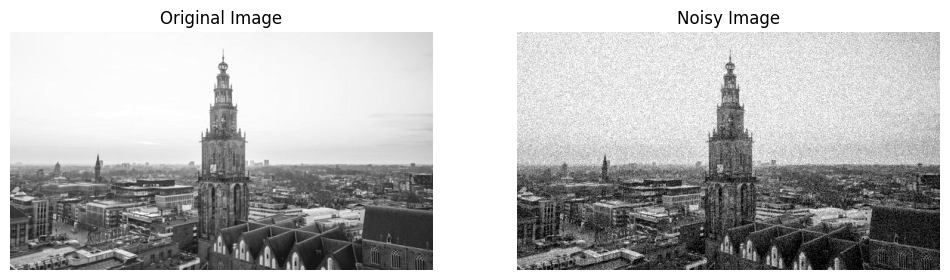

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display as display

# Load the image
image = Image.open('test_image_bw.jpg')

raw_image = np.array(image)
print(raw_image.shape)
desired_image = raw_image - np.mean(raw_image)
noise_level = 20
noise = np.random.normal(-noise_level, noise_level, desired_image.shape)
noisy_image = raw_image + noise

# Convert noisy_image to uint8 and clip values to be in the valid range [0, 255]
noisy_image_uint8 = np.clip(noisy_image, 0, 255).astype(np.uint8)

input_image = desired_image + noise

# Display the image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(noisy_image_uint8, cmap='gray')
ax[1].set_title('Noisy Image')
ax[1].axis('off')

plt.show()
# # Resize the image by 70%
# width, height = image.size
# new_size = (int(width * 0.5), int(height * 0.5))
# resized_image = image.resize(new_size)

# # Convert the image to black and white
# bw_image = resized_image.convert('L')

# # Save the black and white image
# bw_image.save('test_image_bw.jpg')

In [2]:
def mirror_alternate_rows(image):
    img_array = np.array(image)
    
    # Get the height and width of the image
    height, width = img_array.shape
    
    # Mirror every other row starting from the second row
    for row in range(1, height, 2):
        img_array[row] = img_array[row][::-1]
    
    # Convert the modified array back to an image
    # mirrored_img = Image.fromarray(img_array)
    return img_array

def rms_filter_1d(input_image, desired_image, filter_size=3, learning_rate=0.01, start_weights=None, Alternate=True, delta = 1):
    """
    Implements a normalized Recursive Least Squares (RLS) adaptive filter.

    Args:
        input_image (numpy.ndarray): The input signal.
        desired_image (numpy.ndarray): The desired output signal.
        filter_size (int, optional): The size of the filter. Defaults to 3.
        learning_rate (float, optional): The learning rate (forgetting factor lambda in RLS). Defaults to 0.01.
        start_weights (numpy.ndarray, optional): Initial filter weights. Defaults to None.
        Alternate (bool, optional): Flag for preprocessing alternate rows (not part of RLS). Defaults to True.

    Returns:
        tuple: A tuple containing the filtered output image, the error history, and the final filter weights.
    """

    if start_weights is not None:
        weights = start_weights
    else:
        weights = np.zeros(filter_size)

    if Alternate:
        input_image = mirror_alternate_rows(input_image)  # Assuming mirror_alternate_rows is defined elsewhere
        desired_image = mirror_alternate_rows(desired_image)

    if len(input_image.shape) > 1:
        error_history = np.zeros(input_image.shape[0] * input_image.shape[1])
    else:
        error_history = np.zeros(len(input_image))

    input_flat = input_image.flatten()
    desired_flat = desired_image.flatten()
    output_image_flat = np.zeros_like(input_flat)
    input_buffer = np.zeros(filter_size)

    # RLS Initialization
    P = np.eye(filter_size) / 0.0001  # Initialize P with a small positive constant (delta)

    lambda_inv = 1 / delta
    for i in range(len(input_flat)):
        # Update input buffer
        input_buffer = np.roll(input_buffer, -1)
        input_buffer[-1] = input_flat[i]

        # Desired output
        d_k = desired_flat[i]
        
        # Compute gain vector k(n)
        u = input_buffer.reshape(-1, 1)  # Convert to column vector
        k = lambda_inv * P @ u / (1 + lambda_inv * u.T @ P @ u)
        
        # Compute error
        y_k = np.dot(weights, input_buffer)
        e_k = d_k - y_k
        
        # Update weights
        weights += (k.flatten() * e_k)
        
        # Update P matrix
        P = lambda_inv * P - lambda_inv * k @ u.T @ P
        
        # Store results
        output_image_flat[i] = y_k
        error_history[i] = e_k ** 2

    if len(input_image.shape) > 1:
        return mirror_alternate_rows(np.reshape(output_image_flat, (input_image.shape[0], input_image.shape[1]))), error_history, weights
    else:
        return output_image_flat, error_history, weights

def rls_filter_2d(input_image, desired_image, filter_size=3, delta=1e-6, lambda_factor=0.99, start_weights=None, print_error=False, update_weights=True):
    """
    Apply RLS filtering on a 2D image with a given filter size and forgetting factor.

    Parameters:
    - input_image (2D array): Noisy or raw input image.
    - desired_image (2D array): Target or desired output image (e.g., clean version).
    - filter_size (int): Size of the square filter window (e.g., 3 for a 3x3 window).
    - delta (float): Small constant for initializing the inverse correlation matrix P.
    - lambda_factor (float): Forgetting factor (typically close to 1, e.g., 0.99).
    - start_weights (2D array): Initial filter weights (optional).
    - print_error (bool): Whether to print errors during runtime.
    - update_weights (bool): Whether to update weights during filtering.

    Returns:
    - output_image (2D array): Filtered output image.
    - error_image (1D array): Error history (squared errors for each pixel).
    - final_weights (2D array): Final learned filter weights (reshaped to 2D).
    """
    # Initialize filter weights (as flat vector) and inverse correlation matrix
    filter_dim = filter_size * filter_size  # Total number of filter weights
    if start_weights is not None:
        weights = start_weights.flatten()
    else:
        weights = np.zeros(filter_dim)

    P = np.eye(filter_dim) / delta  # Initialize inverse correlation matrix

    # Padding size for the image borders
    pad_size = filter_size // 2
    padded_input = np.pad(input_image, pad_size, mode='constant', constant_values=0)

    # Prepare output images
    output_image = np.zeros_like(input_image)
    error_history = np.zeros(input_image.shape[0] * input_image.shape[1])

    # Loop over each pixel in the input image (excluding padding)
    for i in range(pad_size, padded_input.shape[0] - pad_size):
        # Determine the order of columns for this row (left to right or right to left)
        if (i - pad_size) % 2 == 0:  # Even row: left to right
            column_range = range(pad_size, padded_input.shape[1] - pad_size)
        else:  # Odd row: right to left
            column_range = range(padded_input.shape[1] - pad_size - 1, pad_size - 1, -1)

        for j in column_range:
            # Extract the current filter window (input buffer) and flatten
            input_buffer = padded_input[i - pad_size:i + pad_size + 1, j - pad_size:j + pad_size + 1]
            x = input_buffer.flatten().reshape(-1, 1)  # Column vector

            # Desired output (target pixel value)
            d_k = desired_image[i - pad_size, j - pad_size]

            # Calculate the output y(k) = w.T * x
            y_k = np.dot(weights, x.flatten())

            # Calculate the error e(k) = d(k) - y(k)
            e_k = d_k - y_k

            if update_weights:
                try:
                    # Compute the gain vector k(n)
                    k = np.dot(P, x) / (lambda_factor + np.dot(x.T, np.dot(P, x)))

                    # Update weights: w(k+1) = w(k) + k(n) * e(k)
                    weights += (k.flatten() * e_k)

                    # Update the inverse autocorrelation matrix P(n)
                    P = (P - np.dot(k, np.dot(x.T, P))) / lambda_factor
                    P += 1e-6 * np.eye(filter_dim)  # Add small regularization for stability
                except Exception as err:
                    if print_error:
                        print(f"Error at pixel ({i}, {j}): {err}")

            # Store the output and error in their respective images
            output_image[i - pad_size, j - pad_size] = y_k
            error_history[(i - pad_size) * input_image.shape[1] + (j - pad_size)] = e_k ** 2

    # Reshape final weights into 2D filter for debugging or visualization
    final_weights = weights.reshape((filter_size, filter_size))

    return output_image, error_history, final_weights

# Using a 1 dimensional filter

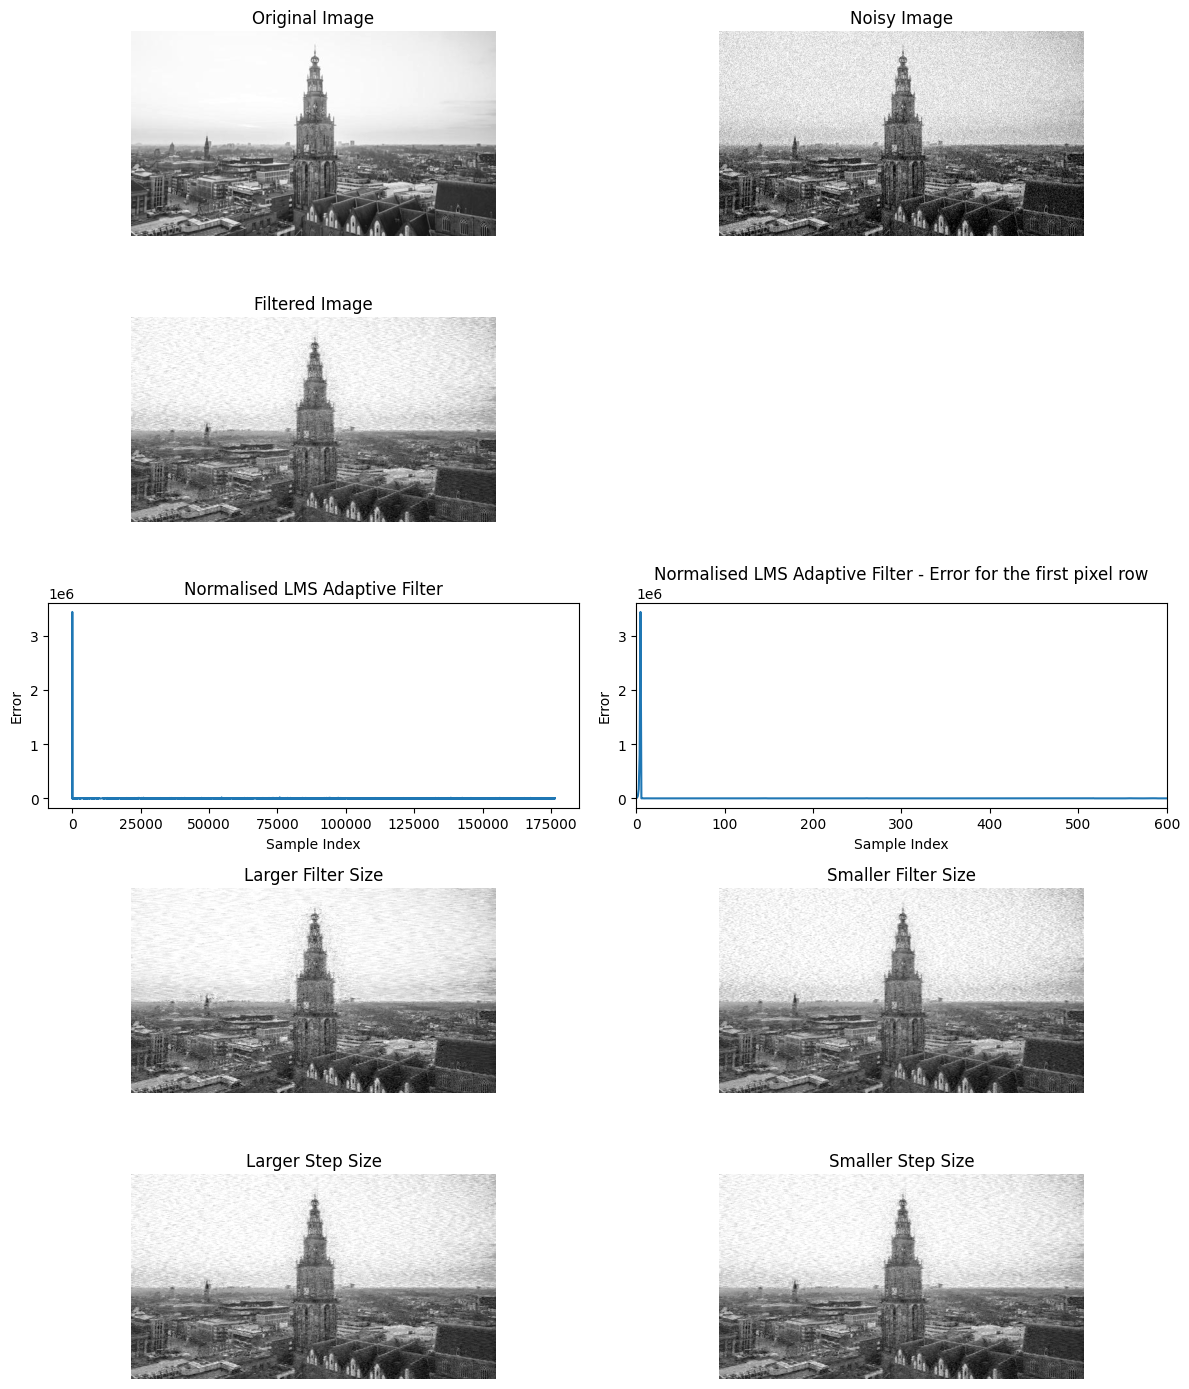

In [3]:
filtered_image, error_history, weights = rms_filter_1d(input_image, desired_image, 5, 0.9995, None, True, 0.9)
larger_step, _,_ = rms_filter_1d(input_image, desired_image, 5, 0.9995, None, True, 0.9)
smaller_step, _,_ = rms_filter_1d(input_image, desired_image, 5, 0.95, None, True, 0.9)
larger_filter, _,_ = rms_filter_1d(input_image, desired_image, 11, 0.995, None, True, 0.9)
smaller_filter, _,_ = rms_filter_1d(input_image, desired_image, 3, 0.995, None, True, 0.9)

# Reshape the output to the original image shape
output_image = filtered_image.reshape(raw_image.shape)
output_image += np.mean(raw_image)
# Clip values to be in the valid range [0, 255] and convert to uint8
output_image_uint8 = np.clip(output_image, 0, 255).astype(np.uint8)

larger_step = larger_step.reshape(raw_image.shape)
larger_step += np.mean(raw_image)
larger_step = np.clip(larger_step, 0, 255).astype(np.uint8)

smaller_step = smaller_step.reshape(raw_image.shape)
smaller_step += np.mean(raw_image)
smaller_step = np.clip(smaller_step, 0, 255).astype(np.uint8)

larger_filter = larger_filter.reshape(raw_image.shape)
larger_filter += np.mean(raw_image)
larger_filter = np.clip(larger_filter, 0, 255).astype(np.uint8)

smaller_filter = smaller_filter.reshape(raw_image.shape)
smaller_filter += np.mean(raw_image)
smaller_filter = np.clip(smaller_filter, 0, 255).astype(np.uint8)

# Display the original, noisy, and output images
fig, ax = plt.subplots(5, 2, figsize=(12, 14))
ax[0, 0].imshow(raw_image, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

ax[0, 1].imshow(noisy_image_uint8, cmap='gray')
ax[0, 1].set_title('Noisy Image')
ax[0, 1].axis('off')

ax[1, 0].imshow(output_image_uint8, cmap='gray')
ax[1, 0 ].set_title('Filtered Image')
ax[1, 0].axis('off')

ax[1, 1].axis('off')

ax[2, 0].plot(error_history, label='Errors')
ax[2, 0].set_xlabel('Sample Index')
ax[2, 0].set_ylabel('Error')
ax[2, 0].set_title('Normalised LMS Adaptive Filter')

ax[2, 1].plot(error_history, label='Errors')
ax[2, 1].set_xlabel('Sample Index')
ax[2, 1].set_ylabel('Error')
ax[2, 1].set_title('Normalised LMS Adaptive Filter - Error for the first pixel row')
ax[2, 1].set_xlim(0, 600)

# Plot larger_filter
ax[3, 0].imshow(larger_filter, cmap='gray')
ax[3, 0].set_title('Larger Filter Size')
ax[3, 0].axis('off')

# Plot smaller_filter
ax[3, 1].imshow(smaller_filter, cmap='gray')
ax[3, 1].set_title('Smaller Filter Size')
ax[3, 1].axis('off')

# Plot larger_step
ax[4, 0].imshow(larger_step, cmap='gray')
ax[4, 0].set_title('Larger Step Size')
ax[4, 0].axis('off')

# Plot smaller_step
ax[4, 1].imshow(smaller_step, cmap='gray')
ax[4, 1].set_title('Smaller Step Size')
ax[4, 1].axis('off')

fig.tight_layout()
plt.show()


# Using a 2D filter
This filter will still zig-zag across the image. 

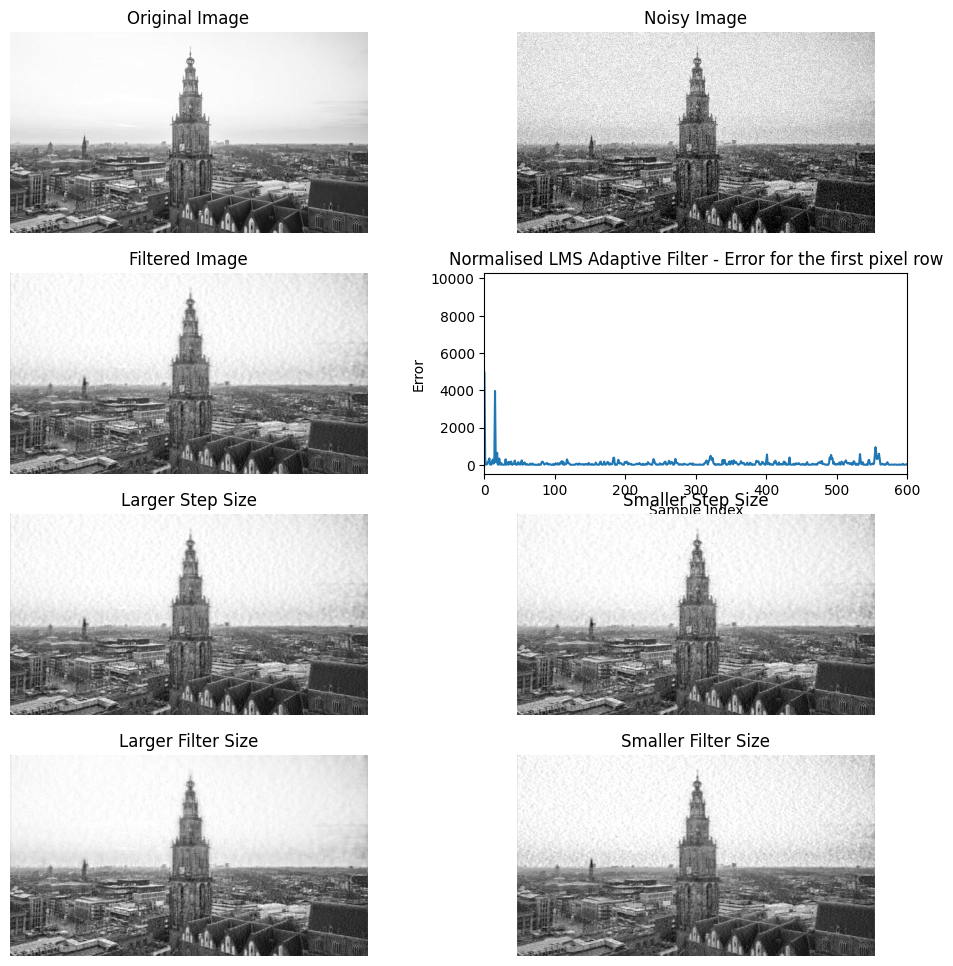

In [4]:
# weights, output, errors = lms_training(input_image, desired_image, 10, 0.00001, 560)
filtered_image, error_history, weights = rls_filter_2d(input_image, desired_image, 5, 0.9, 0.995)
larger_step, _,_ = rls_filter_2d(input_image, desired_image, 5, 0.9, 0.9995)
smaller_step, _,_ = rls_filter_2d(input_image, desired_image, 5, 0.9, 0.95)
larger_filter, _,_ = rls_filter_2d(input_image, desired_image, 9, 0.9, 0.995)
smaller_filter, _,_ = rls_filter_2d(input_image, desired_image, 3, 0.9, 0.995)

# Reshape the output to the original image shape
output_image = filtered_image.reshape(raw_image.shape)
output_image += np.mean(raw_image)
# Clip values to be in the valid range [0, 255] and convert to uint8
output_image_uint8 = np.clip(output_image, 0, 255).astype(np.uint8)

larger_step = larger_step.reshape(raw_image.shape)
larger_step += np.mean(raw_image)
larger_step = np.clip(larger_step, 0, 255).astype(np.uint8)

smaller_step = smaller_step.reshape(raw_image.shape)
smaller_step += np.mean(raw_image)
smaller_step = np.clip(smaller_step, 0, 255).astype(np.uint8)

larger_filter = larger_filter.reshape(raw_image.shape)
larger_filter += np.mean(raw_image)
larger_filter = np.clip(larger_filter, 0, 255).astype(np.uint8)

smaller_filter = smaller_filter.reshape(raw_image.shape)
smaller_filter += np.mean(raw_image)
smaller_filter = np.clip(smaller_filter, 0, 255).astype(np.uint8)

# Display the original, noisy, and output images
fig, ax = plt.subplots(4, 2, figsize=(12, 12))
ax[0, 0].imshow(raw_image, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

ax[0, 1].imshow(noisy_image_uint8, cmap='gray')
ax[0, 1].set_title('Noisy Image')
ax[0, 1].axis('off')

ax[1, 0].imshow(output_image_uint8, cmap='gray')
ax[1, 0 ].set_title('Filtered Image')
ax[1, 0].axis('off')

ax[1, 1].plot(error_history, label='Errors')
ax[1, 1].set_xlabel('Sample Index')
ax[1, 1].set_ylabel('Error')
ax[1, 1].set_title('Normalised LMS Adaptive Filter - Error for the first pixel row')
ax[1, 1].set_xlim(0, 600)

# Plot larger_step
ax[2, 0].imshow(larger_step, cmap='gray')
ax[2, 0].set_title('Larger Step Size')
ax[2, 0].axis('off')

# Plot smaller_step
ax[2, 1].imshow(smaller_step, cmap='gray')
ax[2, 1].set_title('Smaller Step Size')
ax[2, 1].axis('off')

# Plot larger_filter
ax[3, 0].imshow(larger_filter, cmap='gray')
ax[3, 0].set_title('Larger Filter Size')
ax[3, 0].axis('off')

# Plot smaller_filter
ax[3, 1].imshow(smaller_filter, cmap='gray')
ax[3, 1].set_title('Smaller Filter Size')
ax[3, 1].axis('off')

plt.show()


# Checking execution time with increasing filter size
The correlation seems to be linear

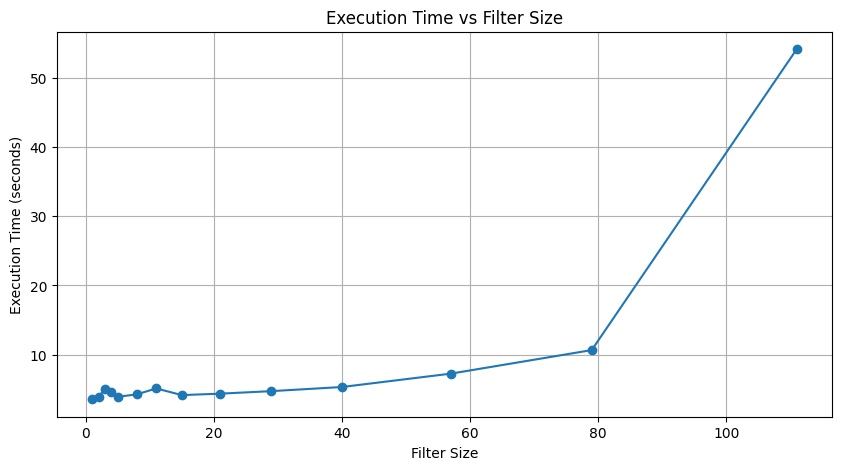

In [5]:
import time

itterations = 15 # 
execution_times = []
x_values = []
for i in range(itterations):
    start_time = time.time()
    filter_size = round(1.4 ** i)
    if filter_size in x_values:
        continue
    filtered_image, error_history, weights = rms_filter_1d(input_image, desired_image, filter_size, 0.9995, None, True, 0.9)
    end_time = time.time()
    execution_times.append(end_time - start_time)
    x_values.append(filter_size)

plt.figure(figsize=(10, 5))
plt.plot(x_values, execution_times, marker='o')
plt.xlabel('Filter Size')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs Filter Size')
plt.grid(True)
plt.show()


# check for tap weights

You should not be getting different weights if you run the algorithm multiple times. Only if you get a picture with different noise in it.

[ 0.14479241  0.2522665  -0.00206751  0.03325247  0.42560198]
[0.07903147 0.06330711 0.09051292 0.059629   0.05310699]


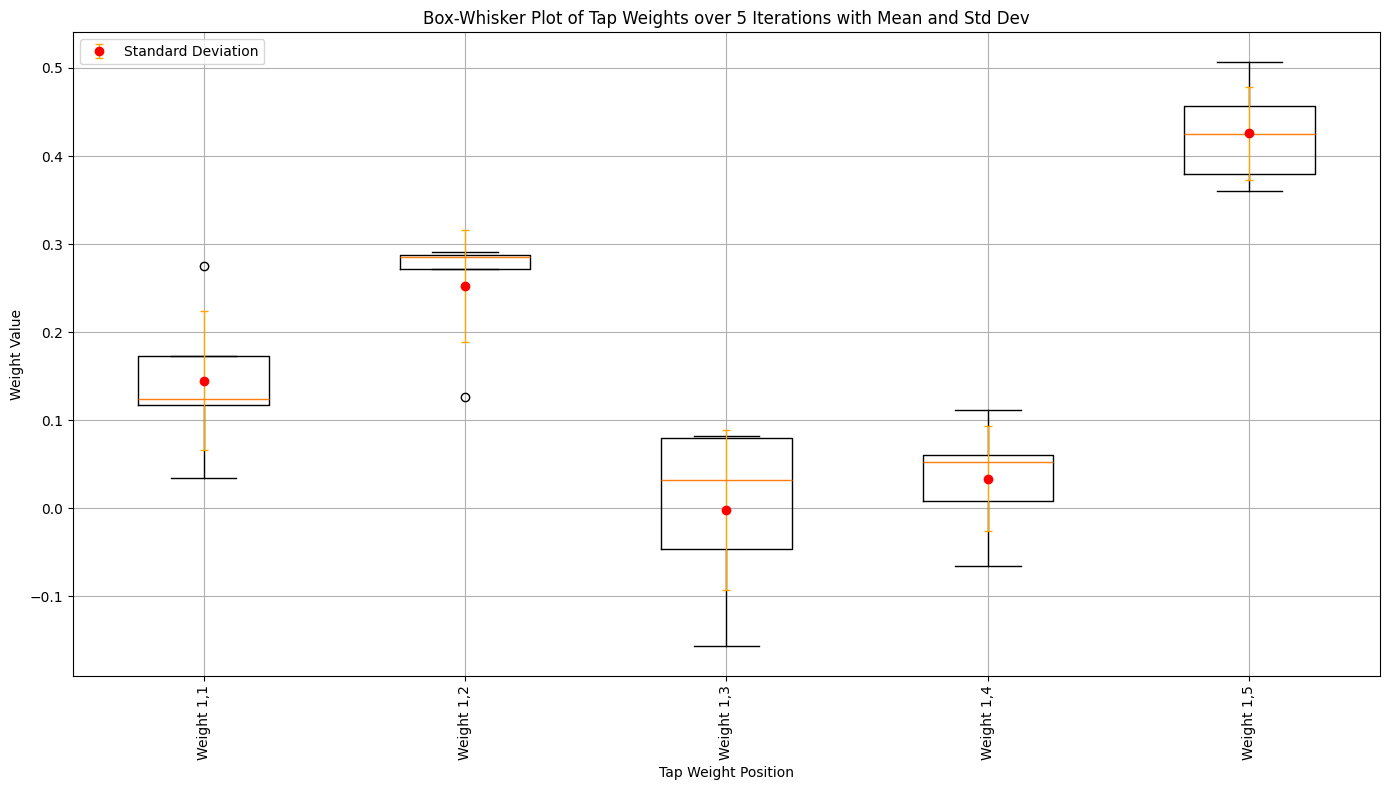

In [6]:
tap_weights = []
itterations = 5
filter_width = 5
desired_image = raw_image - np.mean(raw_image)

for i in range(itterations):
    
    noise_level = 20
    noise = np.random.normal(-noise_level, noise_level, desired_image.shape)
    noisy_image = raw_image + noise

    # Convert noisy_image to uint8 and clip values to be in the valid range [0, 255]
    noisy_image_uint8 = np.clip(noisy_image, 0, 255).astype(np.uint8)

    input_image = desired_image + noise
    filtered_image, error_history, weights = rms_filter_1d(input_image, desired_image, filter_width, 0.9995, None, True, 0.9)
    tap_weights.append(weights)

tap_weights = np.array(tap_weights)  # Shape should be (100, 7) after this conversion

# Transpose to separate each tap weight
tap_weights_reshaped = tap_weights.reshape(itterations, filter_width).T 

mean_values = np.mean(tap_weights_reshaped, axis=1)
std_values = np.std(tap_weights_reshaped, axis=1) 
print(mean_values)
print(std_values)

# Create the boxplot
plt.figure(figsize=(14, 8))
plt.boxplot(tap_weights_reshaped.T, tick_labels=[f'Weight {i//filter_width+1},{i%filter_width+1}' for i in range(filter_width)])
plt.xticks(rotation=90)  # Rotate labels for readability

# Overlay the mean and standard deviation as scatter points
# plt.scatter(range(1, filter_width ** 2 +1), mean_values, color='red', marker='o', label='Mean')
plt.errorbar(range(1, filter_width + 1), mean_values, yerr=std_values, fmt='o', color='red', 
             ecolor='orange', elinewidth=1, capsize=3, label='Standard Deviation')

# Add labels and title
plt.xlabel(f"Tap Weight Position")
plt.ylabel("Weight Value")
plt.title(f"Box-Whisker Plot of Tap Weights over {itterations} Iterations with Mean and Std Dev")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Same weights and noise, different image

(337, 600)


(np.float64(-0.5), np.float64(599.5), np.float64(336.5), np.float64(-0.5))

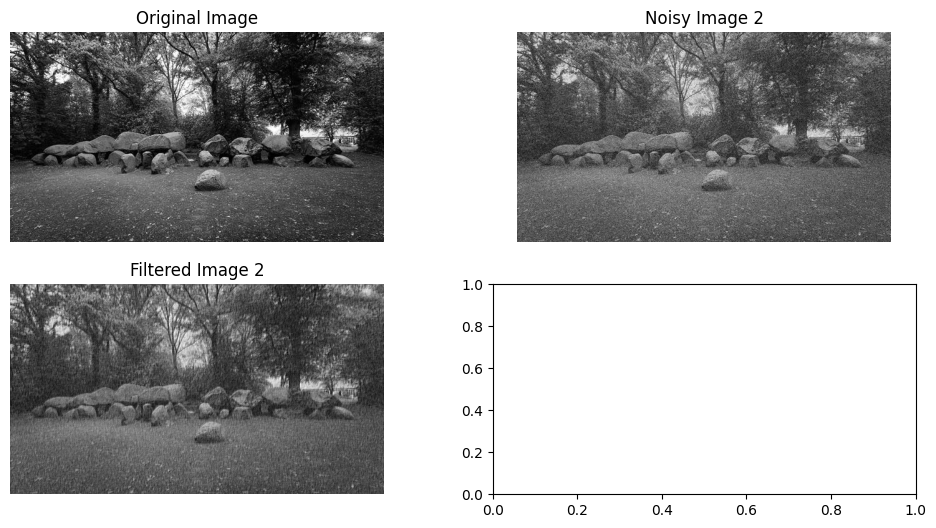

In [7]:
noise_level = 20
noise = np.random.normal(-noise_level, noise_level, (700, 700))
raw_image_shape = raw_image.shape
noise_1 = noise[:raw_image_shape[0], :raw_image_shape[1]]
noisy_image = raw_image + noise_1

# Convert noisy_image to uint8 and clip values to be in the valid range [0, 255]
noisy_image_uint8 = np.clip(noisy_image, 0, 255).astype(np.uint8)
input_image = desired_image + noise_1
filtered_image, error_history, weights = rls_filter_2d(input_image, desired_image, 5, 0.9, 0.995)

image_2 = Image.open('test_image_2_bw.jpg')

raw_image_2 = np.array(image_2)
print(raw_image_2.shape)
desired_image_2 = raw_image_2 - np.mean(raw_image_2)

raw_image_shape_2 = raw_image_2.shape
noise_2 = noise[:raw_image_shape_2[0], :raw_image_shape_2[1]]
noisy_image_2 = raw_image_2 + noise_2

input_image_2 = desired_image_2 + noise_2
filtered_image_2, _, _ = rls_filter_2d(input_image_2, desired_image_2, 5, 0.9, 0.995, weights, False, False)
filtered_image_2 += np.mean(raw_image_2)

# Display the image
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0, 0].imshow(image_2, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

ax[0, 1].imshow(noisy_image_2, cmap='gray')
ax[0, 1].set_title('Noisy Image 2')
ax[0, 1].axis('off')

ax[1, 0].imshow(filtered_image_2, cmap='gray')
ax[1, 0].set_title('Filtered Image 2')
ax[1, 0].axis('off')


# Another method of detecting the error.
It seems the filtered image is a little better than the noisy image.

In [8]:
# Ensure both images are in the same range
image_2_array = np.array(image_2, dtype=np.float64)
noise_image_2_array = np.array(noisy_image_2, dtype=np.float64)
filtered_image_2_array = np.array(filtered_image_2, dtype=np.float64)

# Calculate the normalized difference
normalized_difference = np.abs(image_2_array - filtered_image_2_array) / np.max(np.abs(image_2_array))
normalized_difference_noisy = np.abs(image_2_array - noise_image_2_array) / np.max(np.abs(image_2_array))
print("difference between orginal and noisy image", np.mean(normalized_difference_noisy))
print("difference between orginal and filtered: ", np.mean(normalized_difference))


difference between orginal and noisy image 0.09166194831828038
difference between orginal and filtered:  0.08579932375757168


# Using a gradient image

(256, 256)


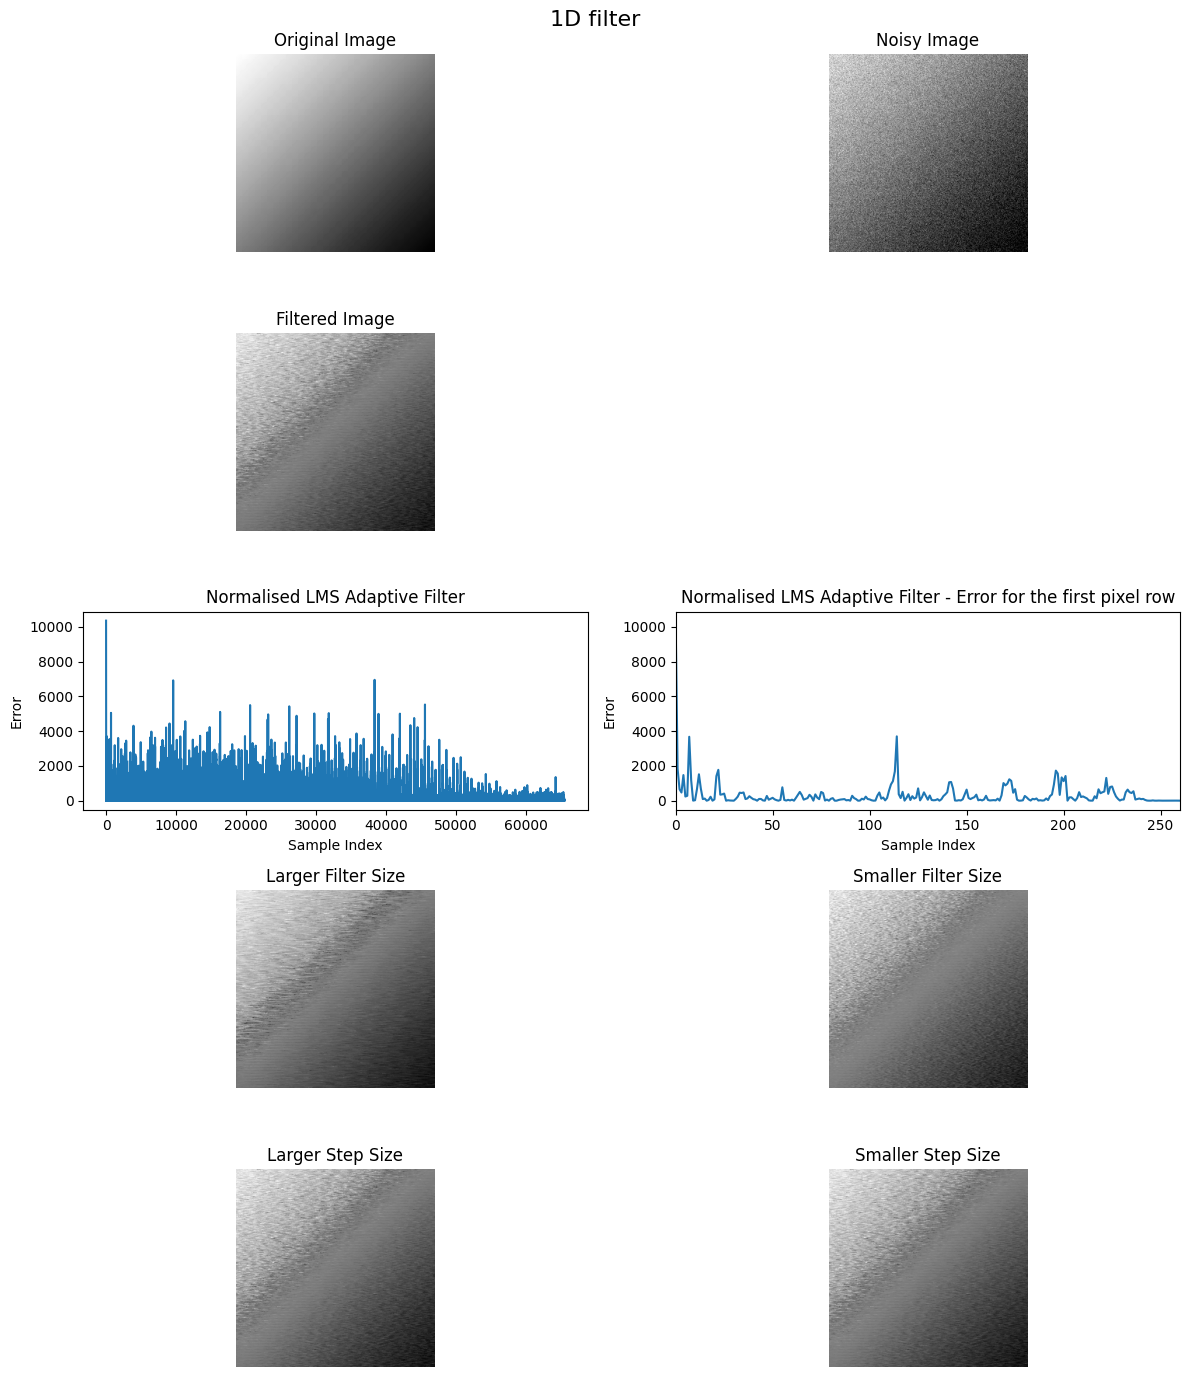

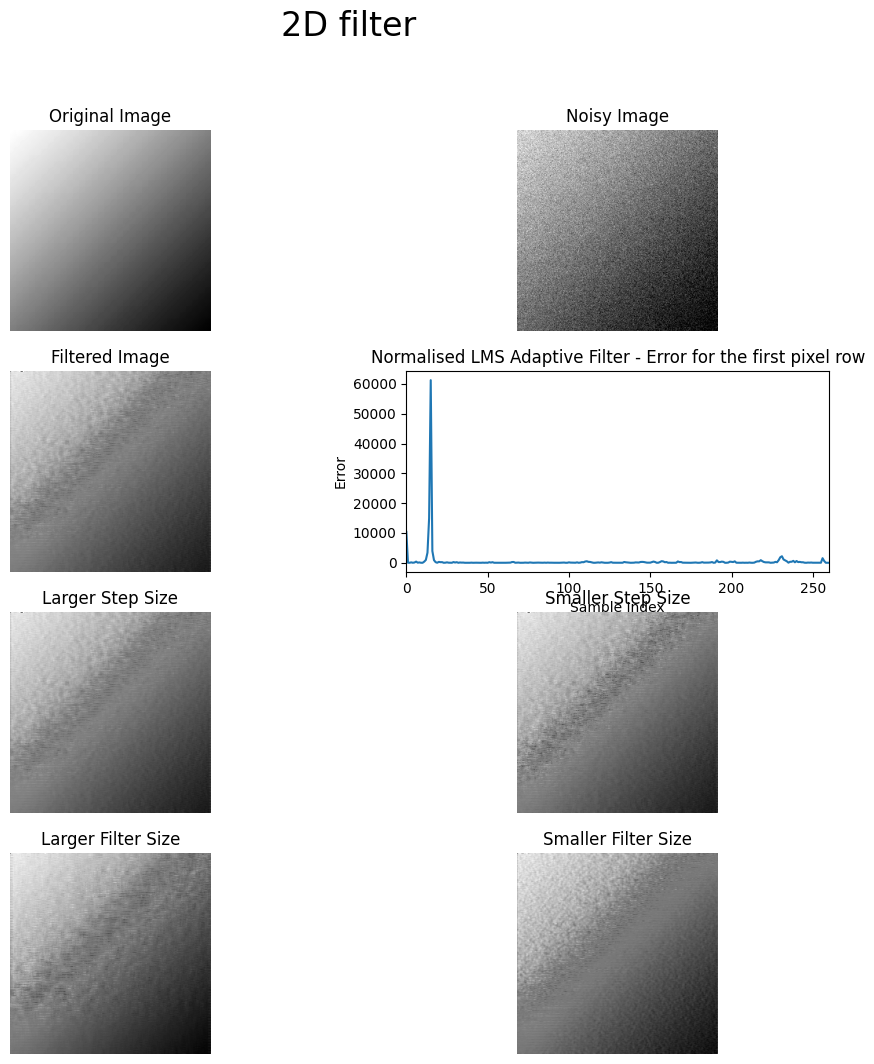

In [9]:
image = Image.open('gradient_bw.jpg')

raw_image = np.array(image)
print(raw_image.shape)
desired_image = raw_image - np.mean(raw_image)
noise_level = 20
noise = np.random.normal(-noise_level, noise_level, desired_image.shape)
noisy_image = raw_image + noise

# Convert noisy_image to uint8 and clip values to be in the valid range [0, 255]
noisy_image_uint8 = np.clip(noisy_image, 0, 255).astype(np.uint8)

input_image = desired_image + noise

filtered_image, error_history, weights = rms_filter_1d(input_image, desired_image, 5, 0.9995, None, True, 0.9)
larger_step, _,_ = rms_filter_1d(input_image, desired_image, 5, 0.9995, None, True, 0.9)
smaller_step, _,_ = rms_filter_1d(input_image, desired_image, 5, 0.95, None, True, 0.9)
larger_filter, _,_ = rms_filter_1d(input_image, desired_image, 11, 0.995, None, True, 0.9)
smaller_filter, _,_ = rms_filter_1d(input_image, desired_image, 3, 0.995, None, True, 0.9)

# Reshape the output to the original image shape
output_image = filtered_image.reshape(raw_image.shape)
output_image += np.mean(raw_image)
# Clip values to be in the valid range [0, 255] and convert to uint8
output_image_uint8 = np.clip(output_image, 0, 255).astype(np.uint8)

larger_step = larger_step.reshape(raw_image.shape)
larger_step += np.mean(raw_image)
larger_step = np.clip(larger_step, 0, 255).astype(np.uint8)

smaller_step = smaller_step.reshape(raw_image.shape)
smaller_step += np.mean(raw_image)
smaller_step = np.clip(smaller_step, 0, 255).astype(np.uint8)

larger_filter = larger_filter.reshape(raw_image.shape)
larger_filter += np.mean(raw_image)
larger_filter = np.clip(larger_filter, 0, 255).astype(np.uint8)

smaller_filter = smaller_filter.reshape(raw_image.shape)
smaller_filter += np.mean(raw_image)
smaller_filter = np.clip(smaller_filter, 0, 255).astype(np.uint8)

# Display the original, noisy, and output images
fig, ax = plt.subplots(5, 2, figsize=(12, 14))
fig.suptitle('1D filter', fontsize=16)
ax[0, 0].imshow(raw_image, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

ax[0, 1].imshow(noisy_image_uint8, cmap='gray')
ax[0, 1].set_title('Noisy Image')
ax[0, 1].axis('off')

ax[1, 0].imshow(output_image_uint8, cmap='gray')
ax[1, 0 ].set_title('Filtered Image')
ax[1, 0].axis('off')

ax[1, 1].axis('off')

ax[2, 0].plot(error_history, label='Errors')
ax[2, 0].set_xlabel('Sample Index')
ax[2, 0].set_ylabel('Error')
ax[2, 0].set_title('Normalised LMS Adaptive Filter')

ax[2, 1].plot(error_history, label='Errors')
ax[2, 1].set_xlabel('Sample Index')
ax[2, 1].set_ylabel('Error')
ax[2, 1].set_title('Normalised LMS Adaptive Filter - Error for the first pixel row')
ax[2, 1].set_xlim(0, 260)

# Plot larger_filter
ax[3, 0].imshow(larger_filter, cmap='gray')
ax[3, 0].set_title('Larger Filter Size')
ax[3, 0].axis('off')

# Plot smaller_filter
ax[3, 1].imshow(smaller_filter, cmap='gray')
ax[3, 1].set_title('Smaller Filter Size')
ax[3, 1].axis('off')

# Plot larger_step
ax[4, 0].imshow(larger_step, cmap='gray')
ax[4, 0].set_title('Larger Step Size')
ax[4, 0].axis('off')

# Plot smaller_step
ax[4, 1].imshow(smaller_step, cmap='gray')
ax[4, 1].set_title('Smaller Step Size')
ax[4, 1].axis('off')

fig.tight_layout()
plt.show()

filtered_image, error_history, weights = rls_filter_2d(input_image, desired_image, 5, 0.9, 0.995)
larger_step, _,_ = rls_filter_2d(input_image, desired_image, 5, 0.9, 0.9995)
smaller_step, _,_ = rls_filter_2d(input_image, desired_image, 5, 0.9, 0.95)
larger_filter, _,_ = rls_filter_2d(input_image, desired_image, 9, 0.9, 0.995)
smaller_filter, _,_ = rls_filter_2d(input_image, desired_image, 3, 0.9, 0.995)

# Reshape the output to the original image shape
output_image = filtered_image.reshape(raw_image.shape)
output_image += np.mean(raw_image)
# Clip values to be in the valid range [0, 255] and convert to uint8
output_image_uint8 = np.clip(output_image, 0, 255).astype(np.uint8)

larger_step = larger_step.reshape(raw_image.shape)
larger_step += np.mean(raw_image)
larger_step = np.clip(larger_step, 0, 255).astype(np.uint8)

smaller_step = smaller_step.reshape(raw_image.shape)
smaller_step += np.mean(raw_image)
smaller_step = np.clip(smaller_step, 0, 255).astype(np.uint8)

larger_filter = larger_filter.reshape(raw_image.shape)
larger_filter += np.mean(raw_image)
larger_filter = np.clip(larger_filter, 0, 255).astype(np.uint8)

smaller_filter = smaller_filter.reshape(raw_image.shape)
smaller_filter += np.mean(raw_image)
smaller_filter = np.clip(smaller_filter, 0, 255).astype(np.uint8)

# Display the original, noisy, and output images
fig, ax = plt.subplots(4, 2, figsize=(12, 12))
fig.suptitle('2D filter', fontsize=24)
ax[0, 0].imshow(raw_image, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 0].axis('off')

ax[0, 1].imshow(noisy_image_uint8, cmap='gray')
ax[0, 1].set_title('Noisy Image')
ax[0, 1].axis('off')

ax[1, 0].imshow(output_image_uint8, cmap='gray')
ax[1, 0 ].set_title('Filtered Image')
ax[1, 0].axis('off')

ax[1, 1].plot(error_history, label='Errors')
ax[1, 1].set_xlabel('Sample Index')
ax[1, 1].set_ylabel('Error')
ax[1, 1].set_title('Normalised LMS Adaptive Filter - Error for the first pixel row')
ax[1, 1].set_xlim(0, 260)

# Plot larger_step
ax[2, 0].imshow(larger_step, cmap='gray')
ax[2, 0].set_title('Larger Step Size')
ax[2, 0].axis('off')

# Plot smaller_step
ax[2, 1].imshow(smaller_step, cmap='gray')
ax[2, 1].set_title('Smaller Step Size')
ax[2, 1].axis('off')

# Plot larger_filter
ax[3, 0].imshow(larger_filter, cmap='gray')
ax[3, 0].set_title('Larger Filter Size')
ax[3, 0].axis('off')

# Plot smaller_filter
ax[3, 1].imshow(smaller_filter, cmap='gray')
ax[3, 1].set_title('Smaller Filter Size')
ax[3, 1].axis('off')

plt.show()

# Audio file

In [17]:
from scipy.io import wavfile
from IPython import display
import numpy as np

# Read the WAV file
sample_rate, normal_audio = wavfile.read('normal_audio.wav')

noise_level = 200
noise = np.random.normal(-noise_level, noise_level, normal_audio.shape)
noisy_audio = normal_audio + noise

print("normal")
display.display(display.Audio(data=normal_audio, rate=sample_rate))
print("noisy")
display.display(display.Audio(data=noisy_audio, rate=sample_rate))

smallest_error = 1000000000000
best_learning_rate = 0
best_filter_size = 0

# for learning_rate in range(3):
#     for filter_size in range(5, 20):
#         filtered_audio, error_history, weights = lms_filter_1d(noisy_audio, normal_audio, filter_size, 0.000000001 * (0.1**learning_rate), None, False)
#         print(f"Learning rate: {0.000000001 * (0.1**learning_rate)}, Filter size: {filter_size}, Average error: {np.mean(error_history)}")
#         display.display(display.Audio(data=filtered_audio, rate=sample_rate))
#         if np.mean(error_history) < smallest_error:
#             smallest_error = np.mean(error_history)
#             best_learning_rate = 0.000000001 * (0.1**learning_rate)
#             best_filter_size = filter_size

print(f"Best learning rate: {best_learning_rate}, Best filter size: {best_filter_size}, Smallest error: {smallest_error}")
# rms_filter_1d(input_image, desired_image, 7, 0.995, None, True, 0.9)
filtered_audio, error_history, weights = rms_filter_1d(noisy_audio, normal_audio, 12, 0.99995, None, False, 0.9)
display.display(display.Audio(data=filtered_audio, rate=sample_rate))


normal


noisy


Best learning rate: 0, Best filter size: 0, Smallest error: 1000000000000


# Large values sine wave

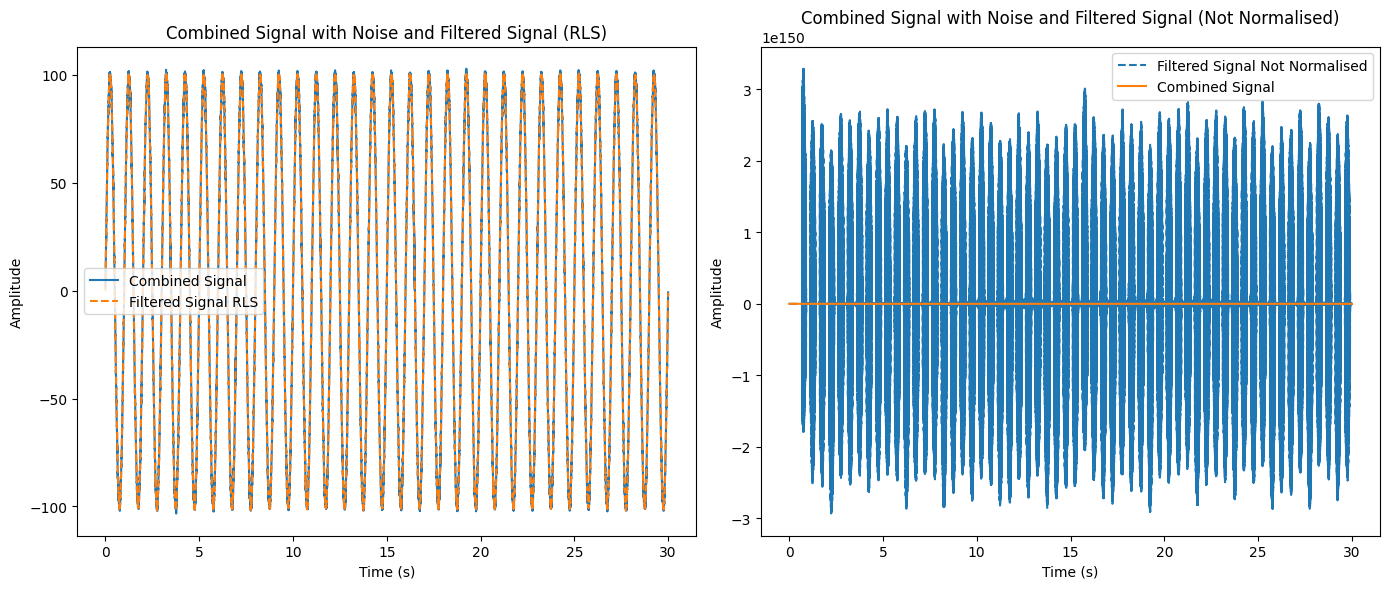

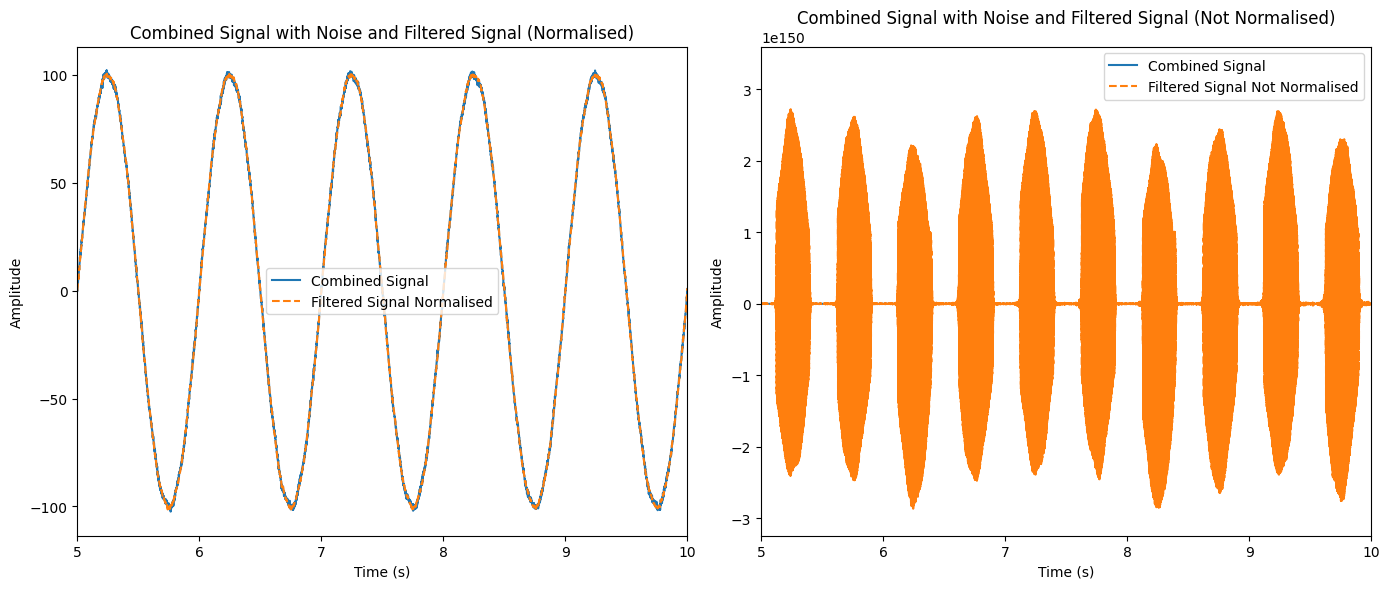

In [11]:
def lms_filter_1d_normalised_or_not(input_image, desired_image, filter_size=3, learning_rate=0.01, start_weights=None, Alternate=True, Normalised=True):
    if start_weights is not None:
        weights = start_weights
    else:
        weights = np.zeros(filter_size)
    
    if Alternate:
        input_image = mirror_alternate_rows(input_image)
        desired_image = mirror_alternate_rows(desired_image)
    
    if len(input_image.shape) > 1:
        error_history = np.zeros(input_image.shape[0] * input_image.shape[1])
    else:
        error_history = np.zeros(len(input_image))
        
    output_weights = None
    
    input_flat = input_image.flatten()
    desired_flat = desired_image.flatten()
    output_image_flat = np.zeros_like(input_flat)
    input_buffer = np.zeros(filter_size)
    
    for i in range(len(input_flat)):
        # Update input buffer with the current measurement
        input_buffer = np.roll(input_buffer, -1)  # Shift left
        input_buffer[-1] = input_flat[i]         # Add new measurement at the end

        # Desired output at this time step
        d_k = desired_flat[i]

        # Calculate the output y(k) = w.T * x (dot product of weights and input buffer)
        y_k = np.dot(weights, input_buffer)

        # Calculate the error e(k) = d(k) - y(k)
        e_k = (d_k - y_k)

        if e_k < 10 and output_weights is None:
               output_weights = weights
           
        if abs(e_k) < 1e-10:
            if e_k > 0:
                e_k = 0.1e-10
            else:
                e_k = -0.1e-10
        
        if abs(e_k) > 1e150:
            if e_k > 0:
                e_k = 1e150
            else:
                e_k = -1e150
                
        # Update weights with w(k+1) = w(k) + μ * e(k) * x
        # weights += learning_rate * e_k * input_buffer

        if Normalised:
            weights += (learning_rate/ (1e-3 + (abs(input_buffer) ** 2)))* e_k * input_buffer
        else:
            weights += learning_rate * e_k * input_buffer

        # Store results
        output_image_flat[i] = y_k
        error_history[i] = e_k ** 2

    if len(input_image.shape) > 1:
        return mirror_alternate_rows(np.reshape(output_image_flat, (input_image.shape[0], input_image.shape[1]))), error_history, output_weights 
    else:
        return output_image_flat, error_history, output_weights

# Parameters for the sine waves
frequency1 = 1  # Frequency of the first sine wave (Hz)
frequency2 = 10  # Frequency of the second sine wave (Hz)
amplitude1 = 100  # Amplitude of the first sine wave
amplitude2 = 1   # Amplitude of the second sine wave
duration = 30     # Duration of the sine waves (seconds)
sample_rate = 1000  # Sampling rate (samples per second)

# Generate time values
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# Generate sine waves
sine_wave1 = amplitude1 * np.sin(2 * np.pi * frequency1 * t)
sine_wave2 = amplitude2 * np.sin(2 * np.pi * frequency2 * t)

# Create small normally distributed noise
noise = np.random.normal(0, 0.7, sine_wave1.shape)

# Sum the sine waves and add noise
combined_signal = sine_wave1 + sine_wave2 + noise

filtered_signal_rls, error_history, weights = rms_filter_1d(combined_signal, sine_wave1, 5, 0.9995, None, False, 0.9)
filtered_signal_not_normalised, error_history, weights = lms_filter_1d_normalised_or_not(combined_signal, sine_wave1, 5, 0.0001, None, False, False)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(t, combined_signal, label='Combined Signal')
plt.plot(t, filtered_signal_rls, label='Filtered Signal RLS', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Combined Signal with Noise and Filtered Signal (RLS)')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(t, filtered_signal_not_normalised, label='Filtered Signal Not Normalised', linestyle='--')
plt.plot(t, combined_signal, label='Combined Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Combined Signal with Noise and Filtered Signal (Not Normalised)')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(t, combined_signal, label='Combined Signal')
plt.plot(t, filtered_signal_rls, label='Filtered Signal Normalised', linestyle='--')
plt.xlim(5, 10)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Combined Signal with Noise and Filtered Signal (Normalised)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, combined_signal, label='Combined Signal')
plt.plot(t, filtered_signal_not_normalised, label='Filtered Signal Not Normalised', linestyle='--')
plt.xlim(5, 10)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Combined Signal with Noise and Filtered Signal (Not Normalised)')
plt.legend()

plt.tight_layout()
plt.show()
